<a href="https://colab.research.google.com/github/defender01/covid_classification/blob/master/covid_classification_efficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install livelossplot
!pip install -q pyyaml h5py
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-25a3wts9
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-25a3wts9
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18424 sha256=35ad8b55d64e4d2f4d0f682364a256b102a379930f2b774635181638a95f210c
  Stored in directory: /tmp/pip-ephem-wheel-cache-zvkdtztz/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.0
    Uninstalling efficientnet-1.1.0:
      Successfully uninstalled efficientnet-1.1.0


In [ ]:
import tensorflow as tf
import math
from os import listdir
from os.path import isfile, join
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import PIL
from IPython.display import Image, display
from keras.applications.vgg16 import VGG16,preprocess_input
# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go
import plotly.graph_objects as go
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from livelossplot import PlotLossesKeras

In [ ]:
# path = "/content/drive/My Drive/covit_dataSet/548681_1157383_bundle_archive"
path = "/content/drive/My Drive/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection"
# path = "/content/drive/My Drive/covit_dataSet/covid-chestxray-dataset-master/covid-chestxray-dataset-master"
# df = pd.read_csv(path+'/metadata.csv')


In [ ]:
# for 2nd dataset
paths = ["/content/drive/My Drive/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection/COVID-19",
         "/content/drive/My Drive/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection/No_findings",
         "/content/drive/My Drive/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection/Pneumonia"]

files = []
for i in range(len(paths)):
  files.append([join(paths[i], f) for f in listdir(paths[i]) if isfile(join(paths[i], f))])

In [ ]:
print(files[0][0])

/content/drive/My Drive/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection/COVID-19/39EE8E69-5801-48DE-B6E3-BE7D1BCF3092.jpeg


In [ ]:
# label 0 for COVID-19, 1 for No_findings, 2 for Pneumonia
dfs = []
for i in range(len(files)):
  print(len(files[i]))
  labels = [i for j in range(len(files[i]))]
  # print(labels)
  dict ={
      'filename': files[i],
      'label': labels
  }
  
  df = pd.DataFrame(dict)
  dfs.append(df)

415
500
500


In [ ]:
dfs[0].head()

,filename,label
0,/content/drive/My Drive/covit_dataSet/COVID-19...,0
1,/content/drive/My Drive/covit_dataSet/COVID-19...,0
2,/content/drive/My Drive/covit_dataSet/COVID-19...,0
3,/content/drive/My Drive/covit_dataSet/COVID-19...,0
4,/content/drive/My Drive/covit_dataSet/COVID-19...,0


In [ ]:
# # creating train dataframe
# train_df = pd.concat( [ 
#                        dfs[0].iloc[: (len(dfs[0])*80)//100],
#                        dfs[1].iloc[: (len(dfs[1])*80)//100],
#                        dfs[2].iloc[: (len(dfs[2])*80)//100] ], ignore_index=True)
# print(train_df.info())
# train_df.head()


In [ ]:
# # creating test dataframe
# test_df = pd.concat( [ 
#                        dfs[0].iloc[(len(dfs[0])*80)//100 : ],
#                        dfs[1].iloc[(len(dfs[1])*80)//100 : ],
#                        dfs[2].iloc[(len(dfs[2])*80)//100 : ] ], ignore_index=True)
# print(test_df.info())
# test_df.head()

In [ ]:
df_collection = pd.concat( [ 
                       dfs[0].iloc[:],
                       dfs[1].iloc[:],
                       dfs[2].iloc[:] ], ignore_index=True)
print(df_collection.info())
df_collection.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415 entries, 0 to 1414
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1415 non-null   object
 1   label     1415 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.2+ KB
None


,filename,label
0,/content/drive/My Drive/covit_dataSet/COVID-19...,0
1,/content/drive/My Drive/covit_dataSet/COVID-19...,0
2,/content/drive/My Drive/covit_dataSet/COVID-19...,0
3,/content/drive/My Drive/covit_dataSet/COVID-19...,0
4,/content/drive/My Drive/covit_dataSet/COVID-19...,0


 **lets look at some x-rays**

covid Cases


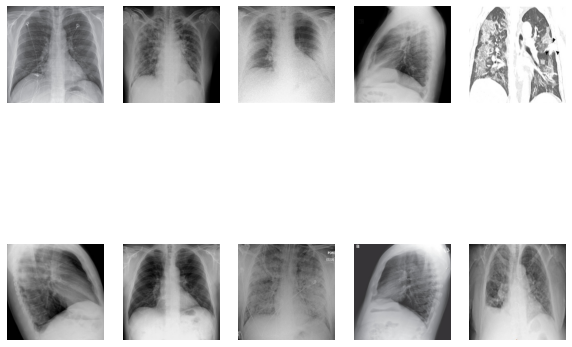

In [ ]:
print('covid Cases')
covidCase=[]
df=dfs[0].sample(10)
df=df.reset_index()
for i in range(10):
    img=cv2.imread(df['filename'].iloc[i])
    # print(img.shape)
    img = cv2.resize(img, (300,300),)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    covidCase.append(img)
f, ax = plt.subplots(2,5, figsize=(10,8))
for i, img in enumerate(covidCase):
        ax[i//5, i%5].imshow(img)
        ax[i//5, i%5].axis('off')
        
plt.show()

No_finding Cases


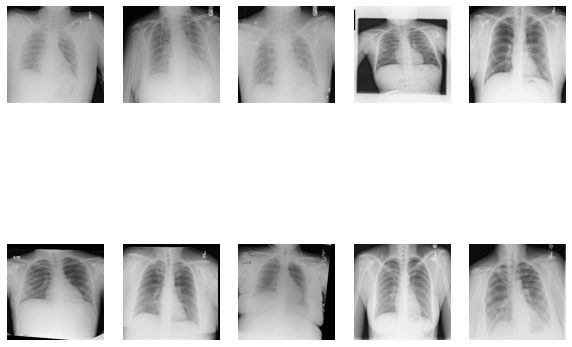

In [ ]:
print('No_finding Cases')
covidCase=[]
df=dfs[1].sample(10)
df=df.reset_index()
for i in range(10):
    img=cv2.imread(df['filename'].iloc[i])
    # print(img.shape)
    img = cv2.resize(img, (300,300),)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    covidCase.append(img)
f, ax = plt.subplots(2,5, figsize=(10,8))
for i, img in enumerate(covidCase):
        ax[i//5, i%5].imshow(img)
        ax[i//5, i%5].axis('off')
        
plt.show()

Pneumonia Cases


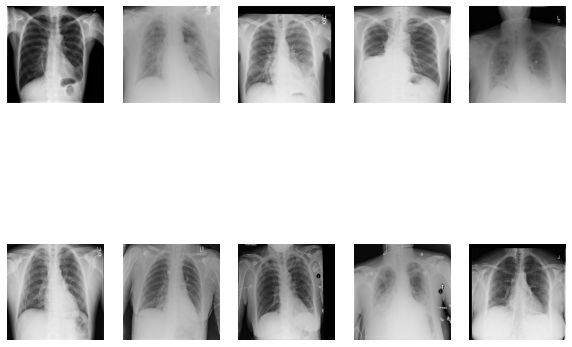

In [ ]:
print('Pneumonia Cases')
covidCase=[]
df=dfs[2].sample(10)
df=df.reset_index()
for i in range(10):
    img=cv2.imread(df['filename'].iloc[i])
    # print(img.shape)
    img = cv2.resize(img, (300,300),)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    covidCase.append(img)
f, ax = plt.subplots(2,5, figsize=(10,8))
for i, img in enumerate(covidCase):
        ax[i//5, i%5].imshow(img)
        ax[i//5, i%5].axis('off')
        
plt.show()

# Preparing Datasets

**creating train and validation set**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_collection['filename'],df_collection['label'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

**Applying some basic preprocessing**


*   normalization
*   reshaping
*   augmentation(only on train data)





In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range= 0.2,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode= 'nearest'
    )
val_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(300, 300),
    batch_size=8,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(300, 300),
    shuffle=False,
    batch_size=8,
    class_mode='raw')



Found 1132 validated image filenames.
Found 283 validated image filenames.


# Creating Model

In [ ]:
import efficientnet.tfkeras as efn
def prtrainedModel(model, shape):
  model_dict= {
      'b0' : efn.EfficientNetB0(include_top=False, weights='imagenet',input_shape=shape),
      'b1' : efn.EfficientNetB0(include_top=False, weights='imagenet',input_shape=shape),
      'b2' : efn.EfficientNetB0(include_top=False, weights='imagenet',input_shape=shape),
      'b3' : efn.EfficientNetB0(include_top=False, weights='imagenet',input_shape=shape),
      'b4' : efn.EfficientNetB0(include_top=False, weights='imagenet',input_shape=shape),
      'b5' : efn.EfficientNetB0(include_top=False, weights='imagenet',input_shape=shape),
      'b6' : efn.EfficientNetB0(include_top=False, weights='imagenet',input_shape=shape),
      'b7' : efn.EfficientNetB0(include_top=False, weights='imagenet',input_shape=shape)
  }

  return model_dict[model]

In [ ]:
def create_model():
  base_model = prtrainedModel('b4', (300, 300, 3))
  base_model.trainable= False
  x= Flatten()(base_model.output)
  # x = Dense(4096, activation='relu')(x)
  # x = Dropout(.3)(x)
  # x = Dense(1024, activation='relu')(x)
  # x = Dropout(.1)(x)
  # x = Dense(512, activation='relu')(x)
  # x = Dropout(.1)(x)
  # x = Dense(128, activation='relu')(x)
  # x = Dropout(.05)(x)
  # x = Dense(64, activation='relu')(x)
  # x = Dense(32, activation='relu')(x)
  # x = Dense(16, activation='relu')(x)
  output=Dense(3,activation='softmax')(x) # because we have to predict the AUC
  model=Model(base_model.input,output)
  
  return model

model = create_model()
model.summary()

In [ ]:
model.compile(optimizer= Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initializing number of => epochs, batch_size, train_steps, val_steps

In [ ]:
no_epochs = 60
batch_size=8
train_steps = train.shape[0]//batch_size
val_steps=validation.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(train_steps,val_steps))

## Call back for reducing learning rate


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
              monitor="val_loss",
              factor=0.2,
              patience=5,
              verbose=1,
              mode="auto",
              min_lr=0
          )

In [ ]:
cb=[PlotLossesKeras(), reduce_lr]
model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs= no_epochs,
    verbose =1,
    validation_data=validation_generator,
    callbacks=cb,
    validation_steps=val_steps)

In [ ]:
 model.save('my_model.h5')